In [ ]:
!pip install -q biopython transformers datasets huggingface_hub accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 34.7 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
import numpy as np
from scipy.special import softmax
import pandas as pd
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
checkpoint = 'LongSafari/hyenadna-small-32k-seqlen-hf'

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels, torch_dtype=torch.bfloat16, device_map="auto", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(checkpoint, trust_remote_code=True)

In [ ]:
class HG38Dataset(torch.utils.data.Dataset):

    def __init__(
        self,
        split,
        path,
        max_length=128,
        tokenizer=None,
    ):

        self.max_length = max_length
        self.tokenizer = tokenizer

        df_raw = pd.read_csv(path, sep = '\t')
        self.df = df_raw[df_raw['split'] == split]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        seq, target = (row[0], row[1])
        seq = tokenizer(seq, padding="max_length", truncation=True, max_length=self.max_length)
        seq = seq["input_ids"]
        seq = torch.LongTensor(seq)
        target = torch.LongTensor([target])
        return seq, target

In [ ]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 12})

def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(np.arange(1, len(train_losses) + 1) * 100, train_losses, label='train')
    axs[0].plot(np.arange(1, len(test_losses) + 1) * 100, test_losses, label='val')
    axs[0].set_ylabel('loss')

    axs[1].plot(np.arange(1, len(train_accuracies) + 1) * 100, train_accuracies, label='train')
    axs[1].plot(np.arange(1, len(test_accuracies) + 1) * 100, test_accuracies, label='val')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('Number of training steps performed')
        ax.legend()

    fig.suptitle('HyenaDNA')

    plt.show()

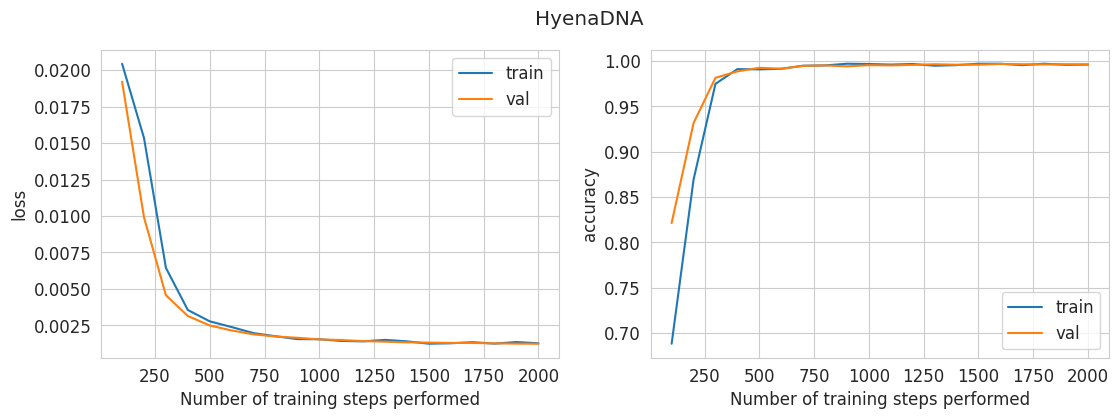

In [ ]:
num_epochs = 1
max_length = 256
path = 'https://drive.google.com/file/d/1hYaaF4DSMaWMogSZJVlMKH85bL15Thb-/view?usp=drive_link'
path = 'https://drive.google.com/uc?id=' + path.split('/')[-2]
batch_size = 32
learning_rate = 1e-05
weight_decay = 1e-04

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

ds_train = HG38Dataset(
    split = 'train',
    path = path,
    max_length = max_length,
    tokenizer=tokenizer
)

ds_test = HG38Dataset(
    split = 'val',
    path = path,
    max_length = max_length,
    tokenizer=tokenizer
)

train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False, drop_last=True)

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

model.to(device)

train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

train_loss, train_accuracy = 0.0, 0.0

for epoch in range(num_epochs):

    model.train()
    for batch_ndx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        if (batch_ndx + 1) == 2001:
          break

        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output['logits'], target.squeeze())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output['logits'].argmax(dim=1, keepdim=True)
        train_accuracy += pred.eq(target.view_as(pred)).sum().item()

        if (batch_ndx + 1) % 100 == 0:

            train_loss /= batch_size * 100
            train_accuracy /= batch_size * 100
            train_losses += [train_loss]
            train_accuracies += [train_accuracy]

            test_loss, test_accuracy = 0.0, 0.0
            model.eval()
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)

                with torch.no_grad():
                    output = model(data)
                    loss = loss_fn(output['logits'], target.squeeze())

                test_loss += loss.item()
                pred = output['logits'].argmax(dim=1, keepdim=True)
                test_accuracy += pred.eq(target.view_as(pred)).sum().item()

            test_loss /= len(test_loader.dataset)
            test_accuracy /= len(test_loader.dataset)
            test_losses += [test_loss]
            test_accuracies += [test_accuracy]
            plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

            train_loss, train_accuracy = 0.0, 0.0

In [ ]:
ds_test = HG38Dataset(
    split = 'test',
    path = path,
    max_length = max_length,
    tokenizer=tokenizer
)

test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False, drop_last=True)

outputs = []
targets = []

model.eval()
for data, target in test_loader:
    data, target = data.to(device), target.to(device)

    with torch.no_grad():
        output = model(data)
        outputs += output['logits'].cpu().tolist()
        targets += target.cpu().tolist()

In [ ]:
def compute_metrics(outputs, targets):
    predictions = np.argmax(outputs, axis=-1)
    scores = softmax(outputs, axis=-1)[:, 1]
    r={'accuracy': accuracy_score(targets, predictions), 'f1_score': f1_score(targets, predictions),
       'ROC_AUC': roc_auc_score(targets, scores)}
    return r

In [ ]:
metrics = compute_metrics(outputs, targets)

print("HyenaDNA")
print(f"Accuracy on the test dataset: %0.4f" % metrics['accuracy'])
print(f"F1-score on the test dataset: %0.4f" % metrics['f1_score'])
print(f"ROC AUC on the test dataset: %0.4f" % metrics['ROC_AUC'])

HyenaDNA
Accuracy on the test dataset: 0.9958
F1-score on the test dataset: 0.9959
ROC AUC on the test dataset: 0.9993
